# Redes Neurais

Este notebook serve como um guia introdutório ao desenvolvimento de redes neurais utilizando a biblioteca PyTorch. Abordaremos os componentes fundamentais da biblioteca, desde a manipulação de tensores até a construção e o treinamento de um modelo de rede neural para classificação de imagens.

## Conteúdos Abordados

1.  **Tensores e Grafos Computacionais**: A base do PyTorch.
2.  **O Módulo `torch.nn`**: Construindo camadas da rede.
3.  **Funções de Ativação**: Introduzindo não linearidade.
4.  **Construindo Modelos**: `nn.Sequential` e classes customizadas com `nn.Module`.
5.  **Datasets e DataLoaders**: Gerenciando e preparando dados com o `torchvision`.
6.  **Funções de Custo (Loss Functions)**: Quantificando o erro do modelo.
7.  **Otimizadores**: Atualizando os pesos do modelo.
8.  **Treinamento**: O ciclo completo de forward, backward e otimização.

## 1. Tensores e Grafos Computacionais

O `Tensor` é a estrutura de dados central do PyTorch. Trata-se de uma matriz multidimensional otimizada para operações em hardware especializado como GPUs. Os tensores são a base para a construção de grafos computacionais dinâmicos, que são essenciais para o cálculo automático de gradientes através do mecanismo de diferenciação automática, conhecido como `autograd`.

In [38]:
import torch

# Criando um tensor a partir de uma lista Python
data_list = [[1, 2], [3, 4]]
x_data = torch.tensor(data_list, dtype=torch.float32)
print(f"Tensor a partir de lista:\n {x_data}\n")

# Funções de criação de tensores
x_ones = torch.ones_like(x_data) # Cria um tensor de 'uns' com o mesmo formato de x_data
print(f"Tensor de 'uns':\n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # Cria um tensor com valores aleatórios
print(f"Tensor aleatório:\n {x_rand} \n")

Tensor a partir de lista:
 tensor([[1., 2.],
        [3., 4.]])

Tensor de 'uns':
 tensor([[1., 1.],
        [1., 1.]]) 

Tensor aleatório:
 tensor([[0.0373, 0.9176],
        [0.7900, 0.9198]]) 



### O Grafo Computacional e o `autograd`

O coração do PyTorch é o `autograd`, seu mecanismo de diferenciação automática. Para que o `autograd` funcione, ele constrói um **grafo computacional** dinamicamente. Este grafo é uma representação de todas as operações executadas nos tensores.

Nesta seção, vamos decompor passo a passo como esse grafo é construído e utilizado para calcular gradientes, usando como exemplo a função:
$$
L = (ab - c)^2
$$

#### Passo 1: Definindo os Tensores Folha com `requires_grad`

O processo começa com a definição dos tensores de entrada. Estes são as "folhas" do nosso grafo. Para que o PyTorch rastreie as operações e calcule os gradientes em relação a eles, devemos definir seu atributo `requires_grad` como `True`.

In [39]:
import torch

# Definindo os tensores de entrada (folhas do grafo)
# Estes são os parâmetros em relação aos quais queremos os gradientes
a = torch.tensor(4.0, requires_grad=True)
b = torch.tensor(5.0, requires_grad=True)
c = torch.tensor(2.0, requires_grad=True)

print(f"Tensor 'a': {a}")
print(f"Tensor 'b': {b}")
print(f"Tensor 'c': {c}")

Tensor 'a': 4.0
Tensor 'b': 5.0
Tensor 'c': 2.0


#### Passo 2: Construindo o Grafo no Forward Pass

À medida que executamos as operações (o *forward pass*), o PyTorch constrói o grafo dinamicamente. Cada novo tensor resultante de uma operação armazena uma referência à função que o criou através do atributo `grad_fn`. Isso cria uma "história" computacional que permite a retropropagação.

In [40]:
# Executando o forward pass para construir o grafo
z = a * b - c
L = z**2

print(f"Resultado intermediário 'z': {z}")
print(f"  - z.grad_fn: {z.grad_fn}\n") # z foi criado por uma subtração (SubBackward0)

print(f"Resultado final 'L': {L}")
print(f"  - L.grad_fn: {L.grad_fn}") # L foi criado por uma potenciação (PowBackward0)

Resultado intermediário 'z': 18.0
  - z.grad_fn: <SubBackward0 object at 0x7cf5554c6ce0>

Resultado final 'L': 324.0
  - L.grad_fn: <PowBackward0 object at 0x7cf5554c6ce0>


#### Passo 3: Calculando os Gradientes com `.backward()`

Com o grafo construído, podemos calcular os gradientes usando o método `.backward()` no tensor de saída final (que deve ser um escalar). Esta chamada inicia o processo de retropropagação a partir de `L`, aplicando a regra da cadeia para calcular as derivadas parciais de `L` em relação a cada tensor folha.

Para o nosso exemplo, o `autograd` calcula:
$$
\frac{\partial L}{\partial a} = \frac{\partial L}{\partial z}\frac{\partial z}{\partial a} = 2(ab - c)b
$$
E de forma análoga para `b` e `c`.

In [41]:
# Inicia a retropropagação a partir de L
L.backward()
print("O método L.backward() foi executado.")

O método L.backward() foi executado.


#### Passo 4: Acessando os Gradientes Calculados

Após a execução de `.backward()`, os gradientes calculados são acumulados no atributo `.grad` dos tensores folha (aqueles que foram inicializados com `requires_grad=True`).

In [42]:
# Os gradientes agora estão disponíveis no atributo .grad de cada tensor folha
print(f"Gradiente dL/da: {a.grad}")
print(f"  - Cálculo manual: 2 * (4*5 - 2) * 5 = {2 * (4*5 - 2) * 5.0}\n")

print(f"Gradiente dL/db: {b.grad}")
print(f"  - Cálculo manual: 2 * (4*5 - 2) * 4 = {2 * (4*5 - 2) * 4.0}\n")

print(f"Gradiente dL/dc: {c.grad}")
print(f"  - Cálculo manual: 2 * (4*5 - 2) * (-1) = {2 * (4*5 - 2) * (-1.0)}")

Gradiente dL/da: 180.0
  - Cálculo manual: 2 * (4*5 - 2) * 5 = 180.0

Gradiente dL/db: 144.0
  - Cálculo manual: 2 * (4*5 - 2) * 4 = 144.0

Gradiente dL/dc: -36.0
  - Cálculo manual: 2 * (4*5 - 2) * (-1) = -36.0


#### Desligando o Rastreamento com `torch.no_grad()`

Para fases de inferência ou avaliação, onde não precisamos de gradientes, é crucial desativar o rastreamento para economizar memória e acelerar a computação. O gerenciador de contexto `with torch.no_grad():` instrui o PyTorch a não construir o grafo computacional para nenhuma operação dentro de seu escopo.

In [43]:
print(f"Rastreamento de gradientes está ativado por padrão para 'a': {a.requires_grad}")

with torch.no_grad():
    print("--- Entrando no bloco no_grad ---")

    # A mesma operação é executada aqui
    L_no_grad = (a * b - c)**2

    print(f"Resultado L_no_grad: {L_no_grad}")
    # O tensor resultante não possui grad_fn, pois a operação não foi rastreada
    print(f"L_no_grad.grad_fn: {L_no_grad.grad_fn}")
    print(f"L_no_grad.requires_grad: {L_no_grad.requires_grad}")

    print("--- Saindo do bloco no_grad ---")

print(f"O rastreamento de gradientes para 'a' continua ativado fora do bloco: {a.requires_grad}")

Rastreamento de gradientes está ativado por padrão para 'a': True
--- Entrando no bloco no_grad ---
Resultado L_no_grad: 324.0
L_no_grad.grad_fn: None
L_no_grad.requires_grad: False
--- Saindo do bloco no_grad ---
O rastreamento de gradientes para 'a' continua ativado fora do bloco: True


## 2. O Módulo `torch.nn`

O `torch.nn` é o módulo do PyTorch para a construção de redes neurais. Ele fornece um conjunto de blocos de construção, como camadas (`Layers`), funções de ativação (`Activation Functions`), funções de custo (`Loss Functions`) e contêineres (`Containers`). Uma "camada" no `torch.nn` é um objeto que encapsula tanto os pesos (parâmetros) quanto as operações a serem aplicadas nos dados de entrada.

### Camada Linear: `nn.Linear`

A camada mais fundamental é a `nn.Linear`, que aplica uma transformação afim aos dados de entrada: $y = xW^T + b$.

-   `in_features`: a dimensionalidade do espaço de entrada.
-   `out_features`: a dimensionalidade do espaço de saída.

Os tensores de peso (`weight`, $W$) e de viés (`bias`, $b$) são encapsulados como `nn.Parameter`, uma subclasse de `torch.Tensor` que os registra automaticamente como parâmetros de um `nn.Module`.

In [44]:
from torch import nn

# Definindo uma camada linear
# Entrada: 10 features
# Saída: 5 features
linear_layer = nn.Linear(in_features=10, out_features=5)

# Criando um tensor de entrada de exemplo (um "batch" com 3 amostras)
# O formato é (batch_size, in_features)
input_tensor = torch.randn(3, 10)

# Passando os dados pela camada
output_tensor = linear_layer(input_tensor)

print(f"Formato do tensor de entrada: {input_tensor.shape}")
print(f"Formato do tensor de saída: {output_tensor.shape}")
print(f"\nPesos (weights) da camada:\n {linear_layer.weight.shape}")
print(f"Viés (bias) da camada:\n {linear_layer.bias.shape}")

Formato do tensor de entrada: torch.Size([3, 10])
Formato do tensor de saída: torch.Size([3, 5])

Pesos (weights) da camada:
 torch.Size([5, 10])
Viés (bias) da camada:
 torch.Size([5])


## 3. Funções de Ativação

Funções de ativação introduzem não linearidade no modelo, capacitando-o a aprender fronteiras de decisão complexas. Elas são aplicadas elemento a elemento na saída de uma camada.

### Funções Comuns

-   **Sigmoid**: Comprime os valores de entrada no intervalo $(0, 1)$. Utilizada historicamente em camadas ocultas e atualmente em camadas de saída para classificação binária.
    $$ \sigma(x) = \frac{1}{1 + e^{-x}} $$
-   **Tanh (Tangente Hiperbólica)**: Comprime os valores de entrada no intervalo $(-1, 1)$. Geralmente converge mais rápido que a Sigmoid por ser centrada em zero.
    $$ \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$
-   **ReLU (Rectified Linear Unit)**: A função de ativação mais utilizada em redes profundas. É computacionalmente eficiente e ajuda a mitigar o problema do desaparecimento do gradiente (vanishing gradient).
    $$ \text{ReLU}(x) = \max(0, x) $$
-   **Leaky ReLU**: Uma variação da ReLU que permite a passagem de um pequeno gradiente negativo, prevenindo o problema dos "neurônios mortos".
    $$ \text{LeakyReLU}(x) = \begin{cases} x, & \text{if } x > 0 \\ \alpha x, & \text{otherwise} \end{cases} $$
-   **Softmax**: Transforma um vetor de números reais (logits) em uma distribuição de probabilidade sobre múltiplas classes. Utilizada na camada de saída para classificação multiclasse.
    $$ \text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}} $$

In [45]:
# As funções de ativação também estão no módulo nn
relu_activation = nn.ReLU()
leaky_relu_activation = nn.LeakyReLU()

# Aplicando a ativação na saída da camada linear anterior
output_with_relu = relu_activation(output_tensor)
output_with_leaky_relu = leaky_relu_activation(output_tensor)

print(f"Saída da camada linear:\n {output_tensor}\n")
print(f"Saída após ativação ReLU:\n {output_with_relu}\n")
print(f"Saída após ativação Leaky ReLU:\n {output_with_leaky_relu}")

Saída da camada linear:
 tensor([[ 0.1765,  0.3281, -0.3440, -1.2423, -0.2612],
        [ 0.0867, -0.3528,  0.1861,  0.0109,  0.3425],
        [-0.9200,  0.5186, -0.3297, -0.1172,  0.9463]],
       grad_fn=<AddmmBackward0>)

Saída após ativação ReLU:
 tensor([[0.1765, 0.3281, 0.0000, 0.0000, 0.0000],
        [0.0867, 0.0000, 0.1861, 0.0109, 0.3425],
        [0.0000, 0.5186, 0.0000, 0.0000, 0.9463]], grad_fn=<ReluBackward0>)

Saída após ativação Leaky ReLU:
 tensor([[ 0.1765,  0.3281, -0.0034, -0.0124, -0.0026],
        [ 0.0867, -0.0035,  0.1861,  0.0109,  0.3425],
        [-0.0092,  0.5186, -0.0033, -0.0012,  0.9463]],
       grad_fn=<LeakyReluBackward0>)


## 4. Construindo Modelos

O PyTorch oferece duas maneiras principais de agrupar camadas para formar um modelo completo.

### `nn.Sequential`

`nn.Sequential` é um contêiner que recebe uma sequência de módulos (camadas, funções de ativação, etc.) e os executa na ordem em que são passados. É uma forma rápida e simples de criar modelos onde os dados fluem sequencialmente através das camadas.

In [46]:
# Construindo um modelo simples com nn.Sequential
model_sequential = nn.Sequential(
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=10)
)

# Criando um tensor de entrada de exemplo
inputs = torch.randn(64, 256)

# Forward pass através do modelo sequencial
logits = model_sequential(inputs) # 'logits' são as saídas brutas antes da probabilidade

print(f"Formato da saída do modelo: {logits.shape}")

Formato da saída do modelo: torch.Size([64, 10])


### Classes customizadas com `nn.Module`

Para modelos mais complexos, como aqueles com múltiplos caminhos de entrada/saída ou lógicas de *forward pass* não sequenciais (e.g., redes residuais), a abordagem recomendada é criar uma classe que herda de `nn.Module`.

Toda classe de modelo customizada deve:
1.  Herdar de `torch.nn.Module`.
2.  Definir as camadas no construtor `__init__(self)`.
3.  Implementar a lógica do *forward pass* no método `forward(self, x)`.

O método `backward()` é gerenciado automaticamente pelo `autograd`.

In [47]:
# Definindo o mesmo modelo anterior, mas agora como uma classe
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out

# Instanciando o modelo
model_class = NeuralNetwork(input_size=256, hidden_size=128, num_classes=10)

# O uso é idêntico
logits_class = model_class(inputs)

print(f"Formato da saída do modelo (classe): {logits_class.shape}")
print(f"\nEstrutura do modelo:\n{model_class}")

Formato da saída do modelo (classe): torch.Size([64, 10])

Estrutura do modelo:
NeuralNetwork(
  (layer1): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=128, out_features=10, bias=True)
)


## 5. Datasets e DataLoaders

Para treinar um modelo, precisamos de um pipeline de dados eficiente. O PyTorch oferece duas primitivas de dados fundamentais para isso: `torch.utils.data.Dataset` e `torch.utils.data.DataLoader`.

### A Estrutura de um `Dataset` Customizado

A classe `Dataset` é uma classe abstrata que representa uma fonte de dados. Para criar seu próprio dataset, você precisa herdar desta classe e sobrescrever três métodos especiais (métodos mágicos):

1.  `__init__(self, ...)`: O construtor da classe. É executado uma única vez ao instanciar o dataset. É aqui que você normalmente faria o carregamento inicial dos dados (ex: ler um arquivo CSV, encontrar os caminhos das imagens em um diretório).

2.  `__len__(self)`: Este método deve retornar o número total de amostras no seu dataset. O `DataLoader` utiliza essa informação para saber o tamanho do dataset e definir os índices.

3.  `__getitem__(self, idx)`: Este método é responsável por carregar e retornar **uma única amostra** do dataset, dado um índice `idx`. É aqui que transformações nos dados (como data augmentation ou normalização) são frequentemente aplicadas.

In [48]:
from torch.utils.data import Dataset

# Exemplo prático de um Dataset customizado com tensores
class SimpleTensorDataset(Dataset):
    def __init__(self, features_tensor, labels_tensor):
        self.features = features_tensor
        self.labels = labels_tensor

    def __len__(self):
        # Retorna o número total de amostras
        return self.features.size(0)

    def __getitem__(self, idx):
        # Retorna uma tupla (feature, label) para um dado índice
        feature_sample = self.features[idx]
        label_sample = self.labels[idx]
        return feature_sample, label_sample

# Criando dados de exemplo
features = torch.randn(500, 64) # 500 amostras, 64 features cada
labels = torch.randint(0, 2, (500,)) # 500 rótulos (0 ou 1)

# Instanciando o nosso dataset customizado
custom_dataset = SimpleTensorDataset(features, labels)

# Verificando a implementação dos métodos
print(f"Tamanho total do dataset: {len(custom_dataset)}")

Tamanho total do dataset: 500


In [49]:
# Pegando a primeira amostra (chamando __getitem__ com idx=0)
first_sample_features, first_sample_label = custom_dataset[0]
print(f"Primeira amostra (features): {first_sample_features.shape}")
print(f"Primeira amostra (label): {first_sample_label}")

Primeira amostra (features): torch.Size([64])
Primeira amostra (label): 0


### O Papel do `DataLoader`

Uma vez que temos um objeto `Dataset`, que sabe como acessar amostras individuais, precisamos de uma forma eficiente de iterar sobre ele durante o treinamento. É aqui que entra o `DataLoader`.

O `DataLoader` é um iterador que envolve um `Dataset` e automatiza o processo de criação de mini-lotes (*mini-batches*). Suas principais funcionalidades são:

-   **Agrupamento em Lotes (Batching)**: Agrupa múltiplas amostras retornadas pelo `__getitem__` do `Dataset` para formar um lote (batch) de dados.
-   **Embaralhamento (Shuffling)**: Permite embaralhar os dados a cada época (`shuffle=True`) para evitar que o modelo aprenda a ordem dos dados e melhore a generalização.
-   **Carregamento Paralelo (Parallel Loading)**: Pode usar múltiplos subprocessos (`num_workers`) para carregar os dados em paralelo, evitando que o carregamento de dados se torne um gargalo.

In [50]:
from torch.utils.data import DataLoader

# Agora, usamos o DataLoader com o 'custom_dataset' que criamos anteriormente
data_loader = DataLoader(dataset=custom_dataset, batch_size=10, shuffle=True)

# O DataLoader é um iterável. Podemos usá-lo em um laço 'for' ou com 'next(iter())'
# para obter o próximo lote de dados.
first_batch_features, first_batch_labels = next(iter(data_loader))

print(f"Formato do batch de features: {first_batch_features.shape}")
print(f"Formato do batch de rótulos: {first_batch_labels.shape}")

Formato do batch de features: torch.Size([10, 64])
Formato do batch de rótulos: torch.Size([10])


### Datasets Disponibilizados: `torchvision`

Compreendida a estrutura de um `Dataset` e o papel do `DataLoader`, podemos apreciar a conveniência de bibliotecas como a `torchvision`. Ela já fornece implementações prontas da classe `Dataset` para datasets populares como o MNIST, que seguem a mesma estrutura que acabamos de ver.

In [51]:
import torchvision
import torchvision.transforms as transforms

# Definindo transformações para os dados
# ToTensor() converte a imagem PIL (H x W x C) no intervalo [0, 255]
# para um FloatTensor (C x H x W) no intervalo [0.0, 1.0].
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Média e desvio padrão do MNIST
])

# Baixando o dataset de treino
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

# Baixando o dataset de teste
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform
)

In [52]:
# Criando os DataLoaders
batch_size = 128
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Iterando sobre o DataLoader para ver o formato de um batch
images, labels = next(iter(train_loader))
print(f"Formato do batch de imagens: {images.shape}") # (batch_size, channels, height, width)
print(f"Formato do batch de rótulos: {labels.shape}")

Formato do batch de imagens: torch.Size([128, 1, 28, 28])
Formato do batch de rótulos: torch.Size([128])


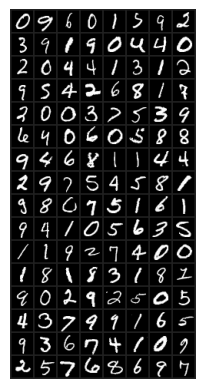

Rótulos:  0 9 6 0 1 5 9 2 3 9 1 9 0 4 4 0 2 0 4 4 1 3 1 2 9 5 4 2 6 8 1 7 2 0 0 3 7 5 3 9 6 4 0 6 0 5 8 8 9 4 6 8 1 1 4 4 2 9 7 5 4 5 8 1 9 8 0 7 5 1 6 1 9 4 1 0 5 6 3 5 1 1 9 2 7 4 0 0 1 8 1 8 3 1 8 1 9 0 2 9 2 5 0 5 4 3 7 9 9 1 6 5 9 3 6 7 4 1 0 9 2 5 7 6 8 6 9 7


In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Função para exibir uma imagem
def imshow(img):
    # A normalização precisa ser revertida para a visualização correta
    # Média = 0.1307, Desvio Padrão = 0.3081
    img = img * 0.3081 + 0.1307
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off') # Remove os eixos
    plt.show()

# Pega um lote (batch) de imagens de treino
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Mostra as imagens em uma grade
# O make_grid organiza o lote de imagens em uma única imagem-grade
imshow(torchvision.utils.make_grid(images))

# Imprime os rótulos correspondentes
print('Rótulos: ', ' '.join(f'{labels[j].item()}' for j in range(batch_size)))

## 6. Funções de Custo (Loss Functions)

A função de custo $J(\theta)$ mede a discrepância entre a saída prevista pelo modelo $\hat{y}$ e o valor real $y$. O objetivo do treinamento é encontrar os parâmetros $\theta$ que minimizam $J(\theta)$.

### Funções Comuns

-   **Mean Squared Error (MSE)**: Utilizada principalmente para tarefas de regressão. Calcula a média dos erros quadráticos entre a previsão e o valor real.
    $$ J_{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 $$
-   **Binary Cross-Entropy (BCE)**: Utilizada para classificação binária. Geralmente é combinada com uma camada de saída Sigmoid.
    $$ J_{BCE} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right] $$
-   **Cross-Entropy Loss**: Utilizada para classificação multiclasse. No PyTorch, `nn.CrossEntropyLoss` combina `nn.LogSoftmax` e `nn.NLLLoss`, sendo numericamente mais estável. Ela espera como entrada os *logits* brutos do modelo e os rótulos de classe como inteiros.
    $$ J_{CE} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(\hat{p}_{i,c}) $$
    Onde $y_{i,c}$ é 1 se a amostra $i$ pertence à classe $c$ (0 caso contrário), e $\hat{p}_{i,c}$ é a probabilidade prevista pelo modelo para a amostra $i$ pertencer à classe $c$.

In [54]:
# Instanciando a função de custo para classificação multiclasse
loss_function = nn.CrossEntropyLoss()

# Exemplo de uso:
# Saída do modelo (logits) para um batch de 3 amostras e 10 classes
output_logits = torch.randn(3, 10)
# Rótulos verdadeiros
target_labels = torch.tensor([1, 4, 9]) # Classe 1, Classe 4, Classe 9

# Calculando a perda
loss = loss_function(output_logits, target_labels)
print(f"Valor da perda (loss): {loss.item()}")

Valor da perda (loss): 4.111000061035156


## 7. Otimizadores

O otimizador implementa o algoritmo de atualização dos parâmetros do modelo, $\theta$, com base nos gradientes da função de custo, $\nabla_{\theta} J(\theta)$. O objetivo é convergir para um mínimo (local ou global) da função de custo.

O algoritmo mais fundamental é o **Stochastic Gradient Descent (SGD)**. A regra de atualização para um parâmetro $\theta$ no passo de tempo $t$ é definida como:
$$
\theta_{t+1} = \theta_t - \eta \nabla_{\theta} J(\theta_t)
$$
onde $\eta$ é a taxa de aprendizado (*learning rate*), um hiperparâmetro que controla o tamanho do passo na direção do gradiente negativo.

Otimizadores mais avançados, como o **Adam (Adaptive Moment Estimation)**, utilizam taxas de aprendizado adaptativas para cada parâmetro, mantendo uma estimativa do primeiro momento (a média) e do segundo momento (a variância não centrada) dos gradientes, o que frequentemente leva a uma convergência mais rápida.

In [55]:
# Instanciando o modelo
learning_rate = 0.001
model = NeuralNetwork(input_size=784, hidden_size=128, num_classes=10)

# Instanciando o otimizador
# Passamos os parâmetros do modelo que devem ser otimizados (model.parameters())
# e a taxa de aprendizado (lr).
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# O otimizador possui métodos cruciais:
# optimizer.zero_grad(): Zera os gradientes de todos os parâmetros antes de um novo cálculo de backward pass.
#   Isto é necessário porque o método .backward() acumula os gradientes por padrão.
#
# optimizer.step(): Atualiza os parâmetros do modelo usando a lógica do otimizador (e.g., Adam) e os gradientes
#   armazenados no atributo .grad de cada parâmetro.

## 8. Treinamento: O Ciclo Completo

O treinamento de uma rede neural consiste em um loop que itera sobre o dataset por várias "épocas" (*epochs*). Uma época é uma passagem completa por todo o dataset de treinamento. Dentro de cada época, iteramos sobre os *batches* de dados.

Para cada *batch*, o ciclo de treinamento é:
1.  **Zerar os gradientes**: Chamar `optimizer.zero_grad()`.
2.  **Forward Pass**: Passar os dados de entrada pelo modelo para obter as previsões (logits).
3.  **Calcular a Perda**: Comparar as previsões com os rótulos verdadeiros usando a função de custo.
4.  **Backward Pass**: Chamar `loss.backward()` para calcular os gradientes da perda em relação a cada parâmetro do modelo.
5.  **Atualizar os Pesos**: Chamar `optimizer.step()` para que o otimizador atualize os pesos com base nos gradientes.

In [56]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Hiperparâmetros
num_epochs = 5
input_size = 784 # 28x28
hidden_size = 500
num_classes = 10
learning_rate = 0.001

# Dispositivo (GPU se disponível, senão CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando o dispositivo: {device}")

# Instanciando o modelo, função de custo e otimizador e movendo o modelo para o dispositivo
model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Listas para armazenar as métricas de cada época
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Loop de treinamento
for epoch in range(num_epochs):
    # --- Treinamento ---
    model.train() # Coloca o modelo em modo de treinamento
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    progress_bar_train = tqdm(train_loader, desc=f'Época [{epoch+1}/{num_epochs}] Treino')

    for images, labels in progress_bar_train:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calcula a acurácia de treino
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        progress_bar_train.set_postfix({'Perda Treino': f'{loss.item():.4f}'})

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # --- Validação ---
    model.eval() # Coloca o modelo em modo de avaliação
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    progress_bar_val = tqdm(test_loader, desc=f'Época [{epoch+1}/{num_epochs}] Validação')

    with torch.no_grad(): # Desabilita o cálculo de gradientes
        for images, labels in progress_bar_val:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Calcula a acurácia de validação
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            progress_bar_val.set_postfix({'Perda Val': f'{loss.item():.4f}'})

    epoch_val_loss = running_val_loss / len(test_loader)
    epoch_val_acc = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f'Fim da Época [{epoch+1}/{num_epochs}] | '
          f'Perda Treino: {epoch_train_loss:.4f}, Acurácia Treino: {epoch_train_acc:.2f}% | '
          f'Perda Validação: {epoch_val_loss:.4f}, Acurácia Validação: {epoch_val_acc:.2f}%')

print("\nTreinamento concluído!")

Usando o dispositivo: cpu


Época [1/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [1/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [1/5] | Perda Treino: 0.2414, Acurácia Treino: 92.75% | Perda Validação: 0.1193, Acurácia Validação: 96.40%


Época [2/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [2/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [2/5] | Perda Treino: 0.0920, Acurácia Treino: 97.21% | Perda Validação: 0.0852, Acurácia Validação: 97.26%


Época [3/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [3/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [3/5] | Perda Treino: 0.0594, Acurácia Treino: 98.17% | Perda Validação: 0.0659, Acurácia Validação: 97.93%


Época [4/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [4/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [4/5] | Perda Treino: 0.0436, Acurácia Treino: 98.58% | Perda Validação: 0.0771, Acurácia Validação: 97.67%


Época [5/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [5/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [5/5] | Perda Treino: 0.0310, Acurácia Treino: 98.99% | Perda Validação: 0.0691, Acurácia Validação: 97.87%

Treinamento concluído!


### Visualização das Curvas de Aprendizado

As curvas de aprendizado plotam as métricas de desempenho (como perda e acurácia) para os conjuntos de treinamento e validação ao longo das épocas. Elas são ferramentas de diagnóstico essenciais:

-   **Curva de Perda (Loss Curve)**: Mostra a evolução da função de custo. Idealmente, ambas as perdas (treino e validação) devem diminuir. Se a perda de validação começar a aumentar enquanto a de treino continua caindo, é um sinal claro de *overfitting*.
-   **Curva de Acurácia (Accuracy Curve)**: Mostra a evolução da acurácia. Idealmente, ambas devem aumentar e convergir. Uma grande diferença entre a acurácia de treino e a de validação também indica *overfitting*.

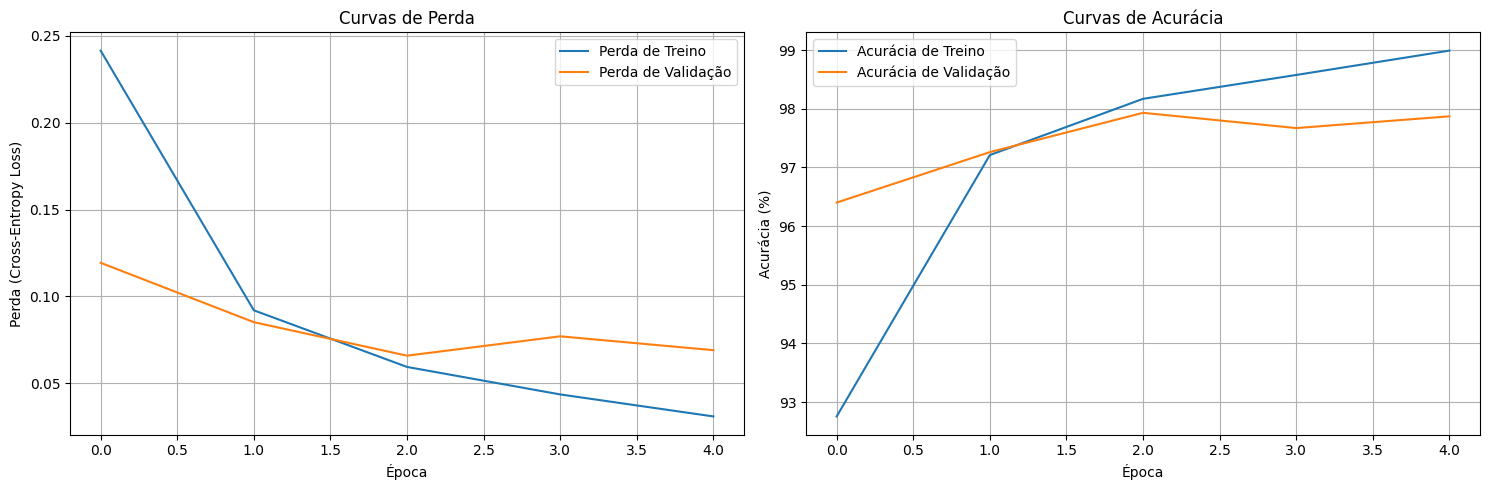

In [57]:
# Criando os plots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot da Curva de Perda
axs[0].plot(train_losses, label='Perda de Treino')
axs[0].plot(val_losses, label='Perda de Validação')
axs[0].set_title("Curvas de Perda")
axs[0].set_xlabel("Época")
axs[0].set_ylabel("Perda (Cross-Entropy Loss)")
axs[0].legend()
axs[0].grid(True)

# Plot da Curva de Acurácia
axs[1].plot(train_accuracies, label='Acurácia de Treino')
axs[1].plot(val_accuracies, label='Acurácia de Validação')
axs[1].set_title("Curvas de Acurácia")
axs[1].set_xlabel("Época")
axs[1].set_ylabel("Acurácia (%)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Avaliação do Modelo

Após o treinamento, é fundamental avaliar a performance do modelo em dados que ele nunca viu, ou seja, o conjunto de teste. Durante a avaliação, não precisamos calcular gradientes, o que economiza memória e computação. Para isso, usamos o contexto `torch.no_grad()`.

In [58]:
# Colocando o modelo em modo de avaliação (desativa camadas como Dropout, se houver)
model.eval()

# O contexto torch.no_grad() desabilita o cálculo de gradientes
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # A classe com o maior logit é a previsão
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Acurácia do modelo no dataset de teste: {100 * correct / total:.2f} %')

Acurácia do modelo no dataset de teste: 97.87 %


### Exercícios

#### Exercício 1: Praticando com o `autograd`

Calcule os gradientes da função $L = 2a^3 + 3b^2$ em relação a `a` e `b`.

1.  Defina dois tensores, `a` e `b`, com os valores `a=2.0` e `b=5.0`. Lembre-se de definir `requires_grad=True`.
2.  Escreva a operação em PyTorch para calcular `L`.
3.  Use `.backward()` para calcular os gradientes.
4.  Imprima `a.grad` e `b.grad`.
5.  **Verificação:** Calcule as derivadas parciais $\frac{\partial L}{\partial a}$ e $\frac{\partial L}{\partial b}$ manualmente e confirme se os resultados correspondem aos do PyTorch.

In [59]:
import torch

a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(5.0, requires_grad=True)

print(f"Tensor 'a': {a}")
print(f"Tensor 'b': {b}")

L = (2 * a**3) + (3 * b**2)

print(f"\nValor de L: {L.item()}")

L.backward()

print(f"\nDerivada parcial a: {a.grad}")
print(f"\nDerivada parcial b: {b.grad}")

# 5. Verificação manual:
# Derivada parcial de L em relação a a: dL/da = d/da (2a^3 + 3b^2) = 6a^2
# Derivada parcial de L em relação a b: dL/db = d/db (2a^3 + 3b^2) = 6b

# Para a=2.0: dL/da = 6 * (2.0)^2 = 6 * 4.0 = 24.0
# Para b=5.0: dL/db = 6 * (5.0) = 30.0

print("\nVerificação manual:")
print(f"Cálculo manual dL/da (para a=2.0): {6 * (2.0)**2}")
print(f"Cálculo manual dL/db (para b=5.0): {6 * 5.0}")

Tensor 'a': 2.0
Tensor 'b': 5.0

Valor de L: 91.0

Derivada parcial a: 24.0

Derivada parcial b: 30.0

Verificação manual:
Cálculo manual dL/da (para a=2.0): 24.0
Cálculo manual dL/db (para b=5.0): 30.0


#### Exercício 2: Aprofundando a Arquitetura da Rede

Modifique a classe `NeuralNetwork` para que ela tenha **duas camadas ocultas** em vez de uma. A nova arquitetura deve ser:
`Entrada (784) -> Camada Linear (256 neurônios) -> ReLU -> Camada Linear (128 neurônios) -> ReLU -> Saída (10 neurônios)`. Em seguida, treine o novo modelo e compare com as curvas de treinamento do modelo original.

In [62]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(128, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.layer3(out)
        return out

# Criando um tensor de entrada de exemplo
inputs = torch.randn(64, 784)

# Instanciando o modelo
model_class = NeuralNetwork()

logits_class = model_class(inputs)

print(f"Formato da saída do modelo (classe): {logits_class.shape}")
print(f"\nEstrutura do modelo:\n{model_class}")

# Dispositivo (GPU se disponível, senão CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando o dispositivo: {device}")

# Instanciando o modelo, função de custo e otimizador e movendo o modelo para o dispositivo
model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Listas para armazenar as métricas de cada época
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Loop de treinamento
for epoch in range(num_epochs):
    # --- Treinamento ---
    model.train() # Coloca o modelo em modo de treinamento
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    progress_bar_train = tqdm(train_loader, desc=f'Época [{epoch+1}/{num_epochs}] Treino')

    for images, labels in progress_bar_train:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calcula a acurácia de treino
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        progress_bar_train.set_postfix({'Perda Treino': f'{loss.item():.4f}'})

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # --- Validação ---
    model.eval() # Coloca o modelo em modo de avaliação
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    progress_bar_val = tqdm(test_loader, desc=f'Época [{epoch+1}/{num_epochs}] Validação')

    with torch.no_grad(): # Desabilita o cálculo de gradientes
        for images, labels in progress_bar_val:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Calcula a acurácia de validação
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            progress_bar_val.set_postfix({'Perda Val': f'{loss.item():.4f}'})

    epoch_val_loss = running_val_loss / len(test_loader)
    epoch_val_acc = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f'Fim da Época [{epoch+1}/{num_epochs}] | '
          f'Perda Treino: {epoch_train_loss:.4f}, Acurácia Treino: {epoch_train_acc:.2f}% | '
          f'Perda Validação: {epoch_val_loss:.4f}, Acurácia Validação: {epoch_val_acc:.2f}%')

print("\nTreinamento concluído!")

Formato da saída do modelo (classe): torch.Size([64, 10])

Estrutura do modelo:
NeuralNetwork(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=128, out_features=10, bias=True)
)
Usando o dispositivo: cpu


Época [1/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [1/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [1/5] | Perda Treino: 0.2738, Acurácia Treino: 91.83% | Perda Validação: 0.1232, Acurácia Validação: 96.07%


Época [2/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [2/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [2/5] | Perda Treino: 0.1037, Acurácia Treino: 96.80% | Perda Validação: 0.1069, Acurácia Validação: 96.59%


Época [3/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [3/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [3/5] | Perda Treino: 0.0703, Acurácia Treino: 97.81% | Perda Validação: 0.0725, Acurácia Validação: 97.80%


Época [4/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [4/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [4/5] | Perda Treino: 0.0499, Acurácia Treino: 98.40% | Perda Validação: 0.0697, Acurácia Validação: 97.78%


Época [5/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [5/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [5/5] | Perda Treino: 0.0408, Acurácia Treino: 98.67% | Perda Validação: 0.0755, Acurácia Validação: 97.94%

Treinamento concluído!


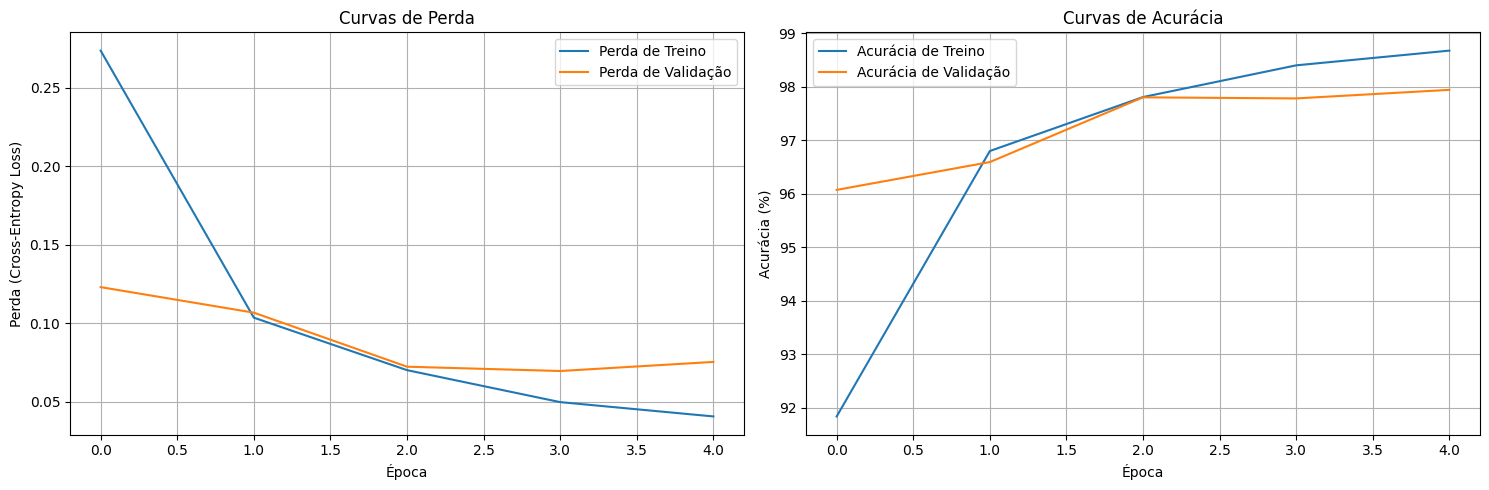

In [63]:
# Criando os plots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot da Curva de Perda
axs[0].plot(train_losses, label='Perda de Treino')
axs[0].plot(val_losses, label='Perda de Validação')
axs[0].set_title("Curvas de Perda")
axs[0].set_xlabel("Época")
axs[0].set_ylabel("Perda (Cross-Entropy Loss)")
axs[0].legend()
axs[0].grid(True)

# Plot da Curva de Acurácia
axs[1].plot(train_accuracies, label='Acurácia de Treino')
axs[1].plot(val_accuracies, label='Acurácia de Validação')
axs[1].set_title("Curvas de Acurácia")
axs[1].set_xlabel("Época")
axs[1].set_ylabel("Acurácia (%)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

#### Exercício 3: Otimizadores e Taxa de Aprendizado

Altere a taxa de aprendizado no loop de treinamento. Utilize valores maiores (como `lr=1.0`) e menores (como `lr=0.0001`) do que o original. Como as curvas de treinamento se comportaram em cada ocasião?

In [69]:
def show_plots(train_losses, val_losses, train_accuracies, val_accuracies):
  # Criando os plots
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))

  # Plot da Curva de Perda
  axs[0].plot(train_losses, label='Perda de Treino')
  axs[0].plot(val_losses, label='Perda de Validação')
  axs[0].set_title("Curvas de Perda")
  axs[0].set_xlabel("Época")
  axs[0].set_ylabel("Perda (Cross-Entropy Loss)")
  axs[0].legend()
  axs[0].grid(True)

  # Plot da Curva de Acurácia
  axs[1].plot(train_accuracies, label='Acurácia de Treino')
  axs[1].plot(val_accuracies, label='Acurácia de Validação')
  axs[1].set_title("Curvas de Acurácia")
  axs[1].set_xlabel("Época")
  axs[1].set_ylabel("Acurácia (%)")
  axs[1].legend()
  axs[1].grid(True)

  plt.tight_layout()
  plt.show()

def train_model(learning_rate):
  # Hiperparâmetros
  num_epochs = 5
  input_size = 784 # 28x28
  hidden_size = 500
  num_classes = 10

  # Dispositivo (GPU se disponível, senão CPU)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print(f"Usando o dispositivo: {device}")

  # Instanciando o modelo, função de custo e otimizador e movendo o modelo para o dispositivo
  model = NeuralNetwork().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Listas para armazenar as métricas de cada época
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  # Loop de treinamento
  for epoch in range(num_epochs):
      # --- Treinamento ---
      model.train() # Coloca o modelo em modo de treinamento
      running_loss = 0.0
      correct_train = 0
      total_train = 0

      progress_bar_train = tqdm(train_loader, desc=f'Época [{epoch+1}/{num_epochs}] Treino')

      for images, labels in progress_bar_train:
          images = images.reshape(-1, 28*28).to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)

          # Backward e otimização
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          # Calcula a acurácia de treino
          _, predicted = torch.max(outputs.data, 1)
          total_train += labels.size(0)
          correct_train += (predicted == labels).sum().item()

          progress_bar_train.set_postfix({'Perda Treino': f'{loss.item():.4f}'})

      epoch_train_loss = running_loss / len(train_loader)
      epoch_train_acc = 100 * correct_train / total_train
      train_losses.append(epoch_train_loss)
      train_accuracies.append(epoch_train_acc)

      # --- Validação ---
      model.eval() # Coloca o modelo em modo de avaliação
      running_val_loss = 0.0
      correct_val = 0
      total_val = 0

      progress_bar_val = tqdm(test_loader, desc=f'Época [{epoch+1}/{num_epochs}] Validação')

      with torch.no_grad(): # Desabilita o cálculo de gradientes
          for images, labels in progress_bar_val:
              images = images.reshape(-1, 28*28).to(device)
              labels = labels.to(device)

              outputs = model(images)
              loss = criterion(outputs, labels)
              running_val_loss += loss.item()

              # Calcula a acurácia de validação
              _, predicted = torch.max(outputs.data, 1)
              total_val += labels.size(0)
              correct_val += (predicted == labels).sum().item()

              progress_bar_val.set_postfix({'Perda Val': f'{loss.item():.4f}'})

      epoch_val_loss = running_val_loss / len(test_loader)
      epoch_val_acc = 100 * correct_val / total_val
      val_losses.append(epoch_val_loss)
      val_accuracies.append(epoch_val_acc)

      print(f'Fim da Época [{epoch+1}/{num_epochs}] | '
            f'Perda Treino: {epoch_train_loss:.4f}, Acurácia Treino: {epoch_train_acc:.2f}% | '
            f'Perda Validação: {epoch_val_loss:.4f}, Acurácia Validação: {epoch_val_acc:.2f}%')

  print("\nTreinamento concluído!")
  show_plots(train_losses, val_losses, train_accuracies, val_accuracies)

Usando o dispositivo: cpu


Época [1/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [1/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [1/5] | Perda Treino: 1514.4692, Acurácia Treino: 10.16% | Perda Validação: 16.9684, Acurácia Validação: 10.10%


Época [2/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [2/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [2/5] | Perda Treino: 11.6488, Acurácia Treino: 10.06% | Perda Validação: 17.0199, Acurácia Validação: 10.10%


Época [3/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [3/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [3/5] | Perda Treino: 2.3394, Acurácia Treino: 10.30% | Perda Validação: 17.0280, Acurácia Validação: 9.82%


Época [4/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [4/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [4/5] | Perda Treino: 2.3420, Acurácia Treino: 10.29% | Perda Validação: 17.0227, Acurácia Validação: 10.31%


Época [5/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [5/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [5/5] | Perda Treino: 2.3509, Acurácia Treino: 9.87% | Perda Validação: 17.0452, Acurácia Validação: 9.82%

Treinamento concluído!


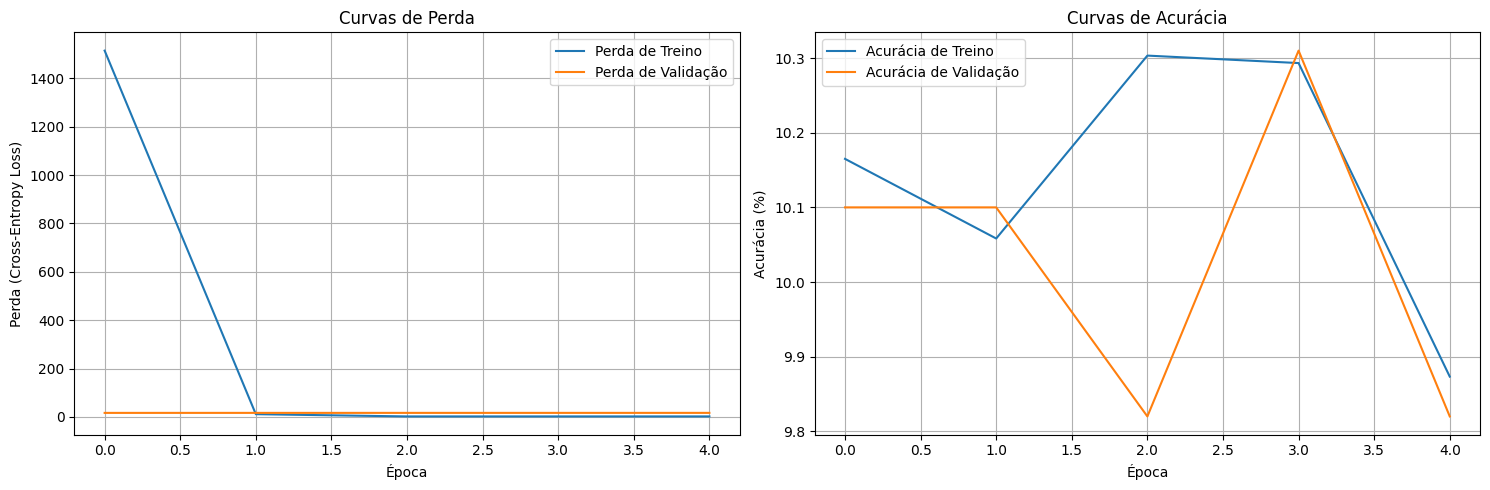

Usando o dispositivo: cpu


Época [1/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [1/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [1/5] | Perda Treino: 0.6627, Acurácia Treino: 83.67% | Perda Validação: 0.2938, Acurácia Validação: 91.32%


Época [2/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [2/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [2/5] | Perda Treino: 0.2667, Acurácia Treino: 92.28% | Perda Validação: 0.2231, Acurácia Validação: 93.59%


Época [3/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [3/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [3/5] | Perda Treino: 0.2095, Acurácia Treino: 93.95% | Perda Validação: 0.1862, Acurácia Validação: 94.56%


Época [4/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [4/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [4/5] | Perda Treino: 0.1734, Acurácia Treino: 94.95% | Perda Validação: 0.1574, Acurácia Validação: 95.29%


Época [5/5] Treino:   0%|          | 0/469 [00:00<?, ?it/s]

Época [5/5] Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Fim da Época [5/5] | Perda Treino: 0.1469, Acurácia Treino: 95.75% | Perda Validação: 0.1384, Acurácia Validação: 95.84%

Treinamento concluído!


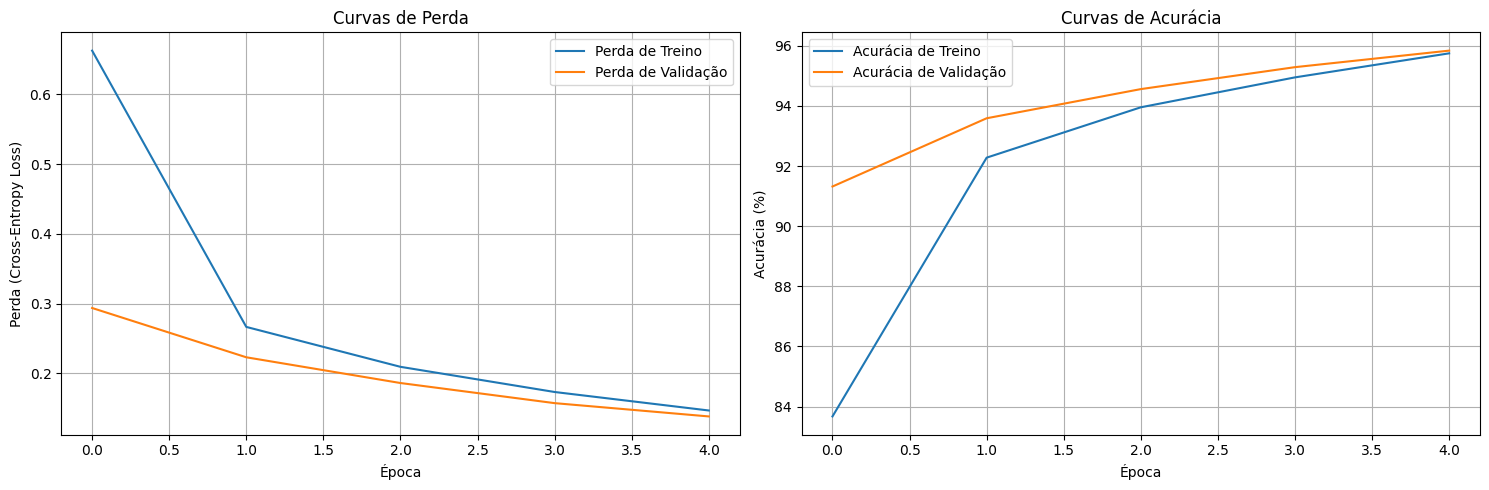

In [70]:
train_model(1.0)
train_model(0.0001)

#### Exercício 4: Criando um Dataset para Regressão

Crie uma classe de `Dataset` customizada para um problema de regressão simples. O dataset deve gerar dados sintéticos onde `y` é uma função linear de `x` com um pouco de ruído.

Crie uma classe `RegressionDataset` que herde de `torch.utils.data.Dataset`. No `__init__`, crie um tensor `X` com 1000 pontos aleatórios entre -10 e 10 e crie um tensor `y` correspondente usando a fórmula $y = 5x - 3 + \text{ruído}$ (use `torch.randn` para o ruído). Implemente os métodos `__len__` e `__getitem__` e use um `DataLoader` para extrair o primeiro lote (batch). Imprima o formato dos tensores de features e labels do lote para confirmar que seu pipeline de dados está funcionando corretamente.

In [71]:
import torch
from torch.utils.data import Dataset, DataLoader

class RegressionDataset(Dataset):
    def __init__(self, num_samples=1000):
        self.X = 20 * torch.rand(num_samples, 1) - 10

        # y = 5x - 3 + ruído
        noise = torch.randn(num_samples, 1) * 2
        self.y = 5 * self.X - 3 + noise

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        feature_sample = self.X[idx]
        label_sample = self.y[idx]
        return feature_sample, label_sample

regression_dataset = RegressionDataset(num_samples=1000)

batch_size = 16
regression_loader = DataLoader(dataset=regression_dataset, batch_size=batch_size, shuffle=True)
features_batch, labels_batch = next(iter(regression_loader))

print(f"Formato do batch de features: {features_batch.shape}")
print(f"Formato do batch de rótulos: {labels_batch.shape}")

print("\nPrimeiro batch de features:\n", features_batch[:5])
print("\nPrimeiro batch de rótulos:\n", labels_batch[:5])

Formato do batch de features: torch.Size([16, 1])
Formato do batch de rótulos: torch.Size([16, 1])

Primeiro batch de features:
 tensor([[3.5511],
        [7.1490],
        [0.2450],
        [5.2347],
        [4.3656]])

Primeiro batch de rótulos:
 tensor([[15.0086],
        [30.6046],
        [-4.6230],
        [20.7376],
        [19.7928]])
